## [RemoteCLIP🛰️: A Vision Language Foundation Model for Remote Sensing](https://arxiv.org/abs/2306.11029)

[Fan Liu (刘凡)](https://multimodality.group/author/%E5%88%98%E5%87%A1/)*
[Delong Chen (陈德龙)](https://chendelong.world/)*
Zhangqingyun Guan (管张青云)
Xiaocong Zhou (周晓聪)
Jiale Zhu (朱佳乐)
[Jun Zhou (周峻)](https://experts.griffith.edu.au/7205-jun-zhou)

\* Equal Contribution

[Github repository](https://github.com/ChenDelong1999/RemoteCLIP/)

[Huggingface model weights](https://huggingface.co/chendelong/RemoteCLIP/tree/main)

-> Run on GPU runtime (top right corner) <-

In [1]:
# @title Install libraries
%%capture
!pip install huggingface_hub open_clip_torch
!git clone https://github.com/ChenDelong1999/RemoteCLIP/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title Load packages and download model weights
from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

# for model_name in ['RN50'] #, 'ViT-B-32', 'ViT-L-14']: #faster loading
for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']: #all models
    checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
    print(f'{model_name} is downloaded to {checkpoint_path}.')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RemoteCLIP-RN50.pt:   0%|          | 0.00/408M [00:00<?, ?B/s]

RN50 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-RN50.pt.


RemoteCLIP-ViT-B-32.pt:   0%|          | 0.00/605M [00:00<?, ?B/s]

ViT-B-32 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt.


RemoteCLIP-ViT-L-14.pt:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

ViT-L-14 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt.


In [4]:
# @title Select Model
model_name = 'ViT-B-32' # @param ['RN50', 'ViT-B-32', 'ViT-L-14']
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

path_to_your_checkpoints = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'

ckpt = torch.load(f"{path_to_your_checkpoints}/RemoteCLIP-{model_name}.pt", map_location="cpu")
message = model.load_state_dict(ckpt)
print(message)
model = model.cuda().eval()

<All keys matched successfully>


In [ ]:
import os
label_file_path = "/content/drive/My Drive/new_cropped_dataset/labels.txt"
true_labels = {}

with open(label_file_path, "r") as f:
    for line in f:
        filename, label = line.strip().split("\t")
        true_labels[filename] = label

image_folder = "/content/drive/MyDrive/new_cropped_dataset/images"
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")]
print("total images: ",len(image_files))

total images:  33396


In [5]:
import os
import random

label_file_path = "/content/drive/My Drive/new_cropped_dataset/labels.txt"
true_labels = {}


with open(label_file_path, "r") as f:
    for line in f:
        filename, label = line.strip().split("\t")
        true_labels[filename] = label


image_folder = "/content/drive/MyDrive/new_cropped_dataset/images"
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")]
print("Total images before selection:", len(image_files))


random.seed(42)
image_files = random.sample(image_files, 15000)

print("Total images after selection:", len(image_files))


Total images before selection: 33396
Total images after selection: 15000


In [6]:
# @title Text caption queries
# text_queries = [
#     "A busy airport with many aeroplanes.",
#     "Satellite view of Hohai university.",
#     "Satellite view of sydney",
#     "A building next to a lake.",
#     "Many people in a stadium.",
#     "a cute cat",
# ]
class_names = [
    "vehicle",
    "baseballfield",
    "windmill",
    "bridge",
    "groundtrackfield",
    "overpass",
    "ship",
    "airplane",
    "tenniscourt",
    "Expressway-Service-area",
    "basketballcourt",
    "storagetank",
    "chimney",
    "airport",
    "stadium",
    "Expressway-toll-station",
    "dam",
    "golffield",
    "trainstation",
    "harbor",
]

text_queries = [
    "A satellite view of a vehicle on a road or parking area.",
    "An aerial view of a baseball field with diamond shape.",
    "A large windmill or wind turbine seen from above.",
    "A bridge crossing over water or a road, viewed from space.",
    "A ground track and field stadium with running lanes.",
    "An overpass where one road crosses over another.",
    "A large cargo ship or boat in a harbor or at sea.",
    "A commercial airplane on a runway or at an airport.",
    "A tennis court with a net in the center seen from above.",
    "An expressway service area with parking and buildings.",
    "A basketball court with hoops at both ends.",
    "A circular or cylindrical storage tank from a top-down view.",
    "An industrial chimney or smokestack with emissions.",
    "A busy airport with multiple runways and terminals.",
    "A stadium for sports or large events viewed from space.",
    "An expressway toll station with booths and vehicles.",
    "A large dam holding back water, viewed from above.",
    "A golf course or golf field with green patches.",
    "A train station with railway tracks and platforms.",
    "A harbor with many boats and loading docks.",
]

text = tokenizer(text_queries)
# image = Image.open("/content/RemoteCLIP/assets/airport.jpg").convert('RGB') #convert to rgb allows it to display as png if the jpg is in cmyk
# display(image)


🔄 Processing Images:   0%|          | 0/15000 [00:00<?, ?it/s]

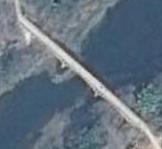

🔄 Processing Images:   0%|          | 1/15000 [00:01<5:22:08,  1.29s/it]


📸 Image: crop_00532.jpg
✅ True Label: bridge
🔮 Predicted Top 1: bridge (99.9%)
📝 Text Query 1: A bridge crossing over water or a road, viewed from space.
🔮 Predicted Top 2: overpass (0.1%)
📝 Text Query 2: An overpass where one road crosses over another.


🔄 Processing Images:   3%|▎         | 500/15000 [02:34<1:08:06,  3.55it/s]

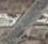

🔄 Processing Images:   3%|▎         | 501/15000 [02:35<1:13:36,  3.28it/s]


📸 Image: crop_30590.jpg
✅ True Label: bridge
🔮 Predicted Top 1: windmill (57.7%)
📝 Text Query 1: A large windmill or wind turbine seen from above.
🔮 Predicted Top 2: basketballcourt (22.4%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:   7%|▋         | 1000/15000 [05:04<1:09:25,  3.36it/s]

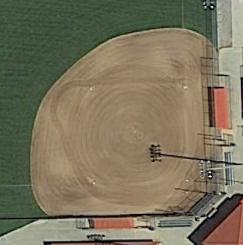

🔄 Processing Images:   7%|▋         | 1001/15000 [05:04<1:04:53,  3.60it/s]


📸 Image: crop_37371.jpg
✅ True Label: baseballfield
🔮 Predicted Top 1: baseballfield (93.2%)
📝 Text Query 1: An aerial view of a baseball field with diamond shape.
🔮 Predicted Top 2: tenniscourt (5.8%)
📝 Text Query 2: A tennis court with a net in the center seen from above.


🔄 Processing Images:  10%|█         | 1500/15000 [07:34<1:12:51,  3.09it/s]

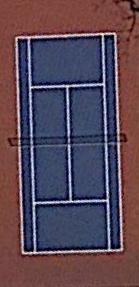

🔄 Processing Images:  10%|█         | 1501/15000 [07:35<1:08:59,  3.26it/s]


📸 Image: crop_34128.jpg
✅ True Label: tenniscourt
🔮 Predicted Top 1: groundtrackfield (75.5%)
📝 Text Query 1: A ground track and field stadium with running lanes.
🔮 Predicted Top 2: tenniscourt (17.7%)
📝 Text Query 2: A tennis court with a net in the center seen from above.


🔄 Processing Images:  13%|█▎        | 2000/15000 [10:03<1:03:02,  3.44it/s]

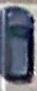

🔄 Processing Images:  13%|█▎        | 2001/15000 [10:04<58:21,  3.71it/s]  


📸 Image: crop_24592.jpg
✅ True Label: vehicle
🔮 Predicted Top 1: ship (96.0%)
📝 Text Query 1: A large cargo ship or boat in a harbor or at sea.
🔮 Predicted Top 2: basketballcourt (1.8%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:  17%|█▋        | 2500/15000 [12:32<53:26,  3.90it/s]

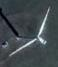

🔄 Processing Images:  17%|█▋        | 2501/15000 [12:32<55:04,  3.78it/s]


📸 Image: crop_19368.jpg
✅ True Label: windmill
🔮 Predicted Top 1: windmill (83.7%)
📝 Text Query 1: A large windmill or wind turbine seen from above.
🔮 Predicted Top 2: dam (12.2%)
📝 Text Query 2: A large dam holding back water, viewed from above.


🔄 Processing Images:  20%|██        | 3000/15000 [15:02<1:00:57,  3.28it/s]

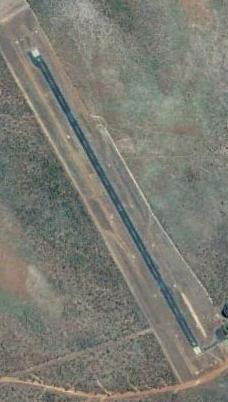

🔄 Processing Images:  20%|██        | 3001/15000 [15:02<1:03:57,  3.13it/s]


📸 Image: crop_15960.jpg
✅ True Label: airport
🔮 Predicted Top 1: overpass (81.6%)
📝 Text Query 1: An overpass where one road crosses over another.
🔮 Predicted Top 2: airplane (14.7%)
📝 Text Query 2: A commercial airplane on a runway or at an airport.


🔄 Processing Images:  23%|██▎       | 3500/15000 [17:32<56:28,  3.39it/s]

🔄 Processing Images:  23%|██▎       | 3501/15000 [17:32<58:27,  3.28it/s]


📸 Image: crop_34384.jpg
✅ True Label: vehicle
🔮 Predicted Top 1: storagetank (71.9%)
📝 Text Query 1: A circular or cylindrical storage tank from a top-down view.
🔮 Predicted Top 2: tenniscourt (14.4%)
📝 Text Query 2: A tennis court with a net in the center seen from above.


🔄 Processing Images:  27%|██▋       | 4000/15000 [20:03<51:25,  3.57it/s]

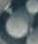

🔄 Processing Images:  27%|██▋       | 4001/15000 [20:04<50:37,  3.62it/s]


📸 Image: crop_14776.jpg
✅ True Label: storagetank
🔮 Predicted Top 1: ship (64.7%)
📝 Text Query 1: A large cargo ship or boat in a harbor or at sea.
🔮 Predicted Top 2: storagetank (20.0%)
📝 Text Query 2: A circular or cylindrical storage tank from a top-down view.


🔄 Processing Images:  30%|███       | 4500/15000 [22:35<53:28,  3.27it/s]

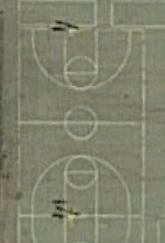

🔄 Processing Images:  30%|███       | 4501/15000 [22:36<56:03,  3.12it/s]


📸 Image: crop_20855.jpg
✅ True Label: basketballcourt
🔮 Predicted Top 1: basketballcourt (100.0%)
📝 Text Query 1: A basketball court with hoops at both ends.
🔮 Predicted Top 2: tenniscourt (0.0%)
📝 Text Query 2: A tennis court with a net in the center seen from above.


🔄 Processing Images:  33%|███▎      | 5000/15000 [25:07<51:19,  3.25it/s]

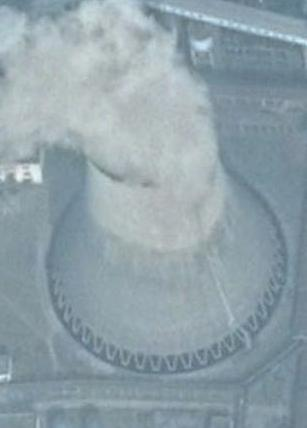

🔄 Processing Images:  33%|███▎      | 5001/15000 [25:08<52:59,  3.14it/s]


📸 Image: crop_19257.jpg
✅ True Label: chimney
🔮 Predicted Top 1: chimney (72.1%)
📝 Text Query 1: An industrial chimney or smokestack with emissions.
🔮 Predicted Top 2: vehicle (10.6%)
📝 Text Query 2: A satellite view of a vehicle on a road or parking area.


🔄 Processing Images:  37%|███▋      | 5500/15000 [27:39<46:21,  3.42it/s]

🔄 Processing Images:  37%|███▋      | 5501/15000 [27:39<45:11,  3.50it/s]


📸 Image: crop_18096.jpg
✅ True Label: vehicle
🔮 Predicted Top 1: storagetank (41.8%)
📝 Text Query 1: A circular or cylindrical storage tank from a top-down view.
🔮 Predicted Top 2: ship (15.3%)
📝 Text Query 2: A large cargo ship or boat in a harbor or at sea.


🔄 Processing Images:  40%|████      | 6000/15000 [30:08<45:40,  3.28it/s]

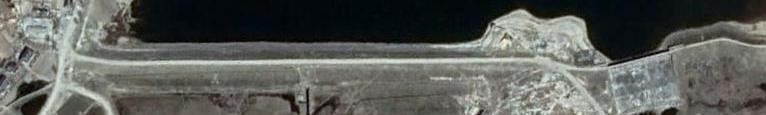

🔄 Processing Images:  40%|████      | 6001/15000 [30:09<47:34,  3.15it/s]


📸 Image: crop_38001.jpg
✅ True Label: dam
🔮 Predicted Top 1: ship (63.6%)
📝 Text Query 1: A large cargo ship or boat in a harbor or at sea.
🔮 Predicted Top 2: basketballcourt (29.1%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:  43%|████▎     | 6500/15000 [32:41<42:41,  3.32it/s]

🔄 Processing Images:  43%|████▎     | 6501/15000 [32:41<43:07,  3.29it/s]


📸 Image: crop_31743.jpg
✅ True Label: overpass
🔮 Predicted Top 1: ship (94.7%)
📝 Text Query 1: A large cargo ship or boat in a harbor or at sea.
🔮 Predicted Top 2: basketballcourt (1.8%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:  47%|████▋     | 7000/15000 [35:14<41:10,  3.24it/s]

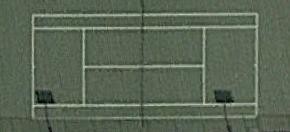

🔄 Processing Images:  47%|████▋     | 7001/15000 [35:14<42:37,  3.13it/s]


📸 Image: crop_17782.jpg
✅ True Label: tenniscourt
🔮 Predicted Top 1: basketballcourt (41.9%)
📝 Text Query 1: A basketball court with hoops at both ends.
🔮 Predicted Top 2: tenniscourt (32.6%)
📝 Text Query 2: A tennis court with a net in the center seen from above.


🔄 Processing Images:  50%|█████     | 7500/15000 [37:47<38:27,  3.25it/s]

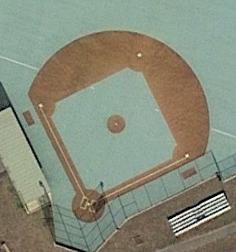

🔄 Processing Images:  50%|█████     | 7501/15000 [37:47<39:17,  3.18it/s]


📸 Image: crop_07021.jpg
✅ True Label: baseballfield
🔮 Predicted Top 1: baseballfield (90.0%)
📝 Text Query 1: An aerial view of a baseball field with diamond shape.
🔮 Predicted Top 2: tenniscourt (6.6%)
📝 Text Query 2: A tennis court with a net in the center seen from above.


🔄 Processing Images:  53%|█████▎    | 8000/15000 [40:18<34:44,  3.36it/s]

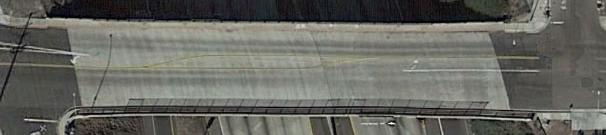

🔄 Processing Images:  53%|█████▎    | 8001/15000 [40:18<33:38,  3.47it/s]


📸 Image: crop_18310.jpg
✅ True Label: overpass
🔮 Predicted Top 1: airplane (81.8%)
📝 Text Query 1: A commercial airplane on a runway or at an airport.
🔮 Predicted Top 2: overpass (7.5%)
📝 Text Query 2: An overpass where one road crosses over another.


🔄 Processing Images:  57%|█████▋    | 8500/15000 [42:47<31:46,  3.41it/s]

🔄 Processing Images:  57%|█████▋    | 8501/15000 [42:47<31:37,  3.43it/s]


📸 Image: crop_28211.jpg
✅ True Label: vehicle
🔮 Predicted Top 1: basketballcourt (25.9%)
📝 Text Query 1: A basketball court with hoops at both ends.
🔮 Predicted Top 2: storagetank (24.1%)
📝 Text Query 2: A circular or cylindrical storage tank from a top-down view.


🔄 Processing Images:  60%|██████    | 9000/15000 [45:17<30:51,  3.24it/s]

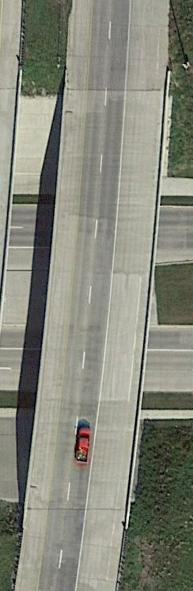

🔄 Processing Images:  60%|██████    | 9001/15000 [45:18<30:19,  3.30it/s]


📸 Image: crop_12744.jpg
✅ True Label: overpass
🔮 Predicted Top 1: overpass (96.8%)
📝 Text Query 1: An overpass where one road crosses over another.
🔮 Predicted Top 2: airplane (2.8%)
📝 Text Query 2: A commercial airplane on a runway or at an airport.


🔄 Processing Images:  63%|██████▎   | 9500/15000 [47:48<26:09,  3.50it/s]

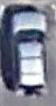

🔄 Processing Images:  63%|██████▎   | 9501/15000 [47:49<26:38,  3.44it/s]


📸 Image: crop_30517.jpg
✅ True Label: vehicle
🔮 Predicted Top 1: basketballcourt (30.8%)
📝 Text Query 1: A basketball court with hoops at both ends.
🔮 Predicted Top 2: storagetank (12.0%)
📝 Text Query 2: A circular or cylindrical storage tank from a top-down view.


🔄 Processing Images:  67%|██████▋   | 10000/15000 [50:22<24:54,  3.35it/s]

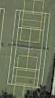

🔄 Processing Images:  67%|██████▋   | 10001/15000 [50:22<25:07,  3.32it/s]


📸 Image: crop_19139.jpg
✅ True Label: tenniscourt
🔮 Predicted Top 1: tenniscourt (61.3%)
📝 Text Query 1: A tennis court with a net in the center seen from above.
🔮 Predicted Top 2: basketballcourt (26.8%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:  70%|███████   | 10500/15000 [52:54<21:31,  3.48it/s]

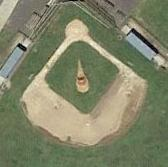

🔄 Processing Images:  70%|███████   | 10501/15000 [52:55<22:04,  3.40it/s]


📸 Image: crop_37599.jpg
✅ True Label: baseballfield
🔮 Predicted Top 1: baseballfield (100.0%)
📝 Text Query 1: An aerial view of a baseball field with diamond shape.
🔮 Predicted Top 2: basketballcourt (0.0%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:  73%|███████▎  | 11000/15000 [55:27<17:54,  3.72it/s]

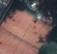

🔄 Processing Images:  73%|███████▎  | 11001/15000 [55:27<18:54,  3.52it/s]


📸 Image: crop_30772.jpg
✅ True Label: tenniscourt
🔮 Predicted Top 1: ship (90.4%)
📝 Text Query 1: A large cargo ship or boat in a harbor or at sea.
🔮 Predicted Top 2: basketballcourt (3.6%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:  77%|███████▋  | 11500/15000 [57:58<14:49,  3.93it/s]

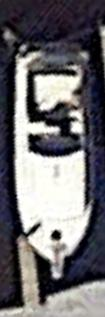

🔄 Processing Images:  77%|███████▋  | 11501/15000 [57:58<15:45,  3.70it/s]


📸 Image: crop_22348.jpg
✅ True Label: ship
🔮 Predicted Top 1: storagetank (41.3%)
📝 Text Query 1: A circular or cylindrical storage tank from a top-down view.
🔮 Predicted Top 2: basketballcourt (12.8%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:  80%|████████  | 12000/15000 [1:00:27<17:35,  2.84it/s]

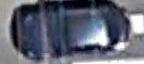

🔄 Processing Images:  80%|████████  | 12001/15000 [1:00:27<17:14,  2.90it/s]


📸 Image: crop_01660.jpg
✅ True Label: vehicle
🔮 Predicted Top 1: basketballcourt (36.4%)
📝 Text Query 1: A basketball court with hoops at both ends.
🔮 Predicted Top 2: chimney (27.9%)
📝 Text Query 2: An industrial chimney or smokestack with emissions.


🔄 Processing Images:  83%|████████▎ | 12500/15000 [1:02:59<13:13,  3.15it/s]

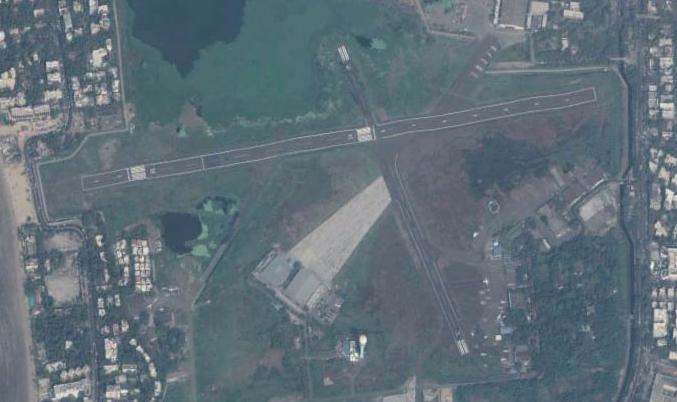

🔄 Processing Images:  83%|████████▎ | 12501/15000 [1:03:00<13:56,  2.99it/s]


📸 Image: crop_09212.jpg
✅ True Label: airport
🔮 Predicted Top 1: bridge (80.9%)
📝 Text Query 1: A bridge crossing over water or a road, viewed from space.
🔮 Predicted Top 2: dam (16.8%)
📝 Text Query 2: A large dam holding back water, viewed from above.


🔄 Processing Images:  87%|████████▋ | 13000/15000 [1:05:32<10:20,  3.23it/s]

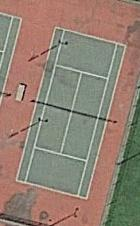

🔄 Processing Images:  87%|████████▋ | 13001/15000 [1:05:32<10:29,  3.18it/s]


📸 Image: crop_27481.jpg
✅ True Label: tenniscourt
🔮 Predicted Top 1: tenniscourt (94.2%)
📝 Text Query 1: A tennis court with a net in the center seen from above.
🔮 Predicted Top 2: groundtrackfield (3.2%)
📝 Text Query 2: A ground track and field stadium with running lanes.


🔄 Processing Images:  90%|█████████ | 13500/15000 [1:08:04<08:18,  3.01it/s]

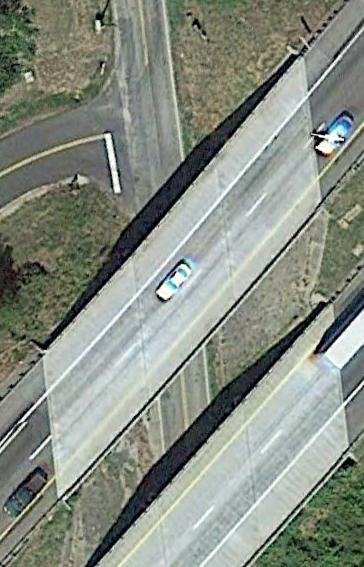

🔄 Processing Images:  90%|█████████ | 13501/15000 [1:08:04<08:54,  2.81it/s]


📸 Image: crop_14762.jpg
✅ True Label: overpass
🔮 Predicted Top 1: overpass (99.7%)
📝 Text Query 1: An overpass where one road crosses over another.
🔮 Predicted Top 2: bridge (0.3%)
📝 Text Query 2: A bridge crossing over water or a road, viewed from space.


🔄 Processing Images:  93%|█████████▎| 14000/15000 [1:10:34<05:38,  2.96it/s]

🔄 Processing Images:  93%|█████████▎| 14001/15000 [1:10:34<05:40,  2.93it/s]


📸 Image: crop_24221.jpg
✅ True Label: vehicle
🔮 Predicted Top 1: ship (88.5%)
📝 Text Query 1: A large cargo ship or boat in a harbor or at sea.
🔮 Predicted Top 2: basketballcourt (3.8%)
📝 Text Query 2: A basketball court with hoops at both ends.


🔄 Processing Images:  97%|█████████▋| 14500/15000 [1:13:05<02:27,  3.38it/s]

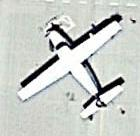

🔄 Processing Images:  97%|█████████▋| 14501/15000 [1:13:05<02:34,  3.23it/s]


📸 Image: crop_01212.jpg
✅ True Label: airplane
🔮 Predicted Top 1: airplane (98.3%)
📝 Text Query 1: A commercial airplane on a runway or at an airport.
🔮 Predicted Top 2: airport (1.5%)
📝 Text Query 2: A busy airport with multiple runways and terminals.


🔄 Processing Images: 100%|██████████| 15000/15000 [1:15:36<00:00,  3.31it/s]


In [7]:
# @title Predicted probabilities
# image = preprocess(image).unsqueeze(0)

# with torch.no_grad(), torch.cuda.amp.autocast():
#     image_features = model.encode_image(image.cuda())
#     text_features = model.encode_text(text.cuda())
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)

#     text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

# print(f'Predictions of {model_name}:')
# for query, prob in zip(text_queries, text_probs):
#     print(f"{query:<40} {prob * 100:5.1f}%")

from tqdm import tqdm

results = {}

for idx, image_file in enumerate(tqdm(image_files, desc="🔄 Processing Images")):
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).convert("RGB")
    # display(image)
    image_input = preprocess(image).unsqueeze(0).cuda()

    with torch.no_grad():
        image_features = model.encode_image(image_input.cuda())
        text_features = model.encode_text(text.cuda())

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

    # Get top 2 predicted indices and labels
    top2_indices = text_probs.argsort()[-2:][::-1]
    top2_labels = [class_names[i] for i in top2_indices]
    top2_probs = [text_probs[i] for i in top2_indices]
    top2_queries = [text_queries[i] for i in top2_indices]

    # Get true label
    true_label = true_labels.get(image_file, "unknown")

    if top2_labels[1]==true_label:
        results[image_file] = top2_labels[1]
    else:
        results[image_file] = top2_labels[0]

    if idx % 500 == 0:
        display(image)
        print(f"\n📸 Image: {image_file}")
        print(f"✅ True Label: {true_label}")
        print(f"🔮 Predicted Top 1: {top2_labels[0]} ({top2_probs[0]*100:.1f}%)")
        print(f"📝 Text Query 1: {top2_queries[0]}")
        print(f"🔮 Predicted Top 2: {top2_labels[1]} ({top2_probs[1]*100:.1f}%)")
        print(f"📝 Text Query 2: {top2_queries[1]}")


In [8]:
correct = 0
total = len(results)
print((results))

for image_file, predicted in results.items():
    true_label = true_labels.get(image_file, "unknown")
    predicted_label = predicted  # predicted = (label, confidence)

    if predicted_label == true_label:
        correct += 1

accuracy = correct / total

print(f"Accuracy: {accuracy * 100:.2f}%")


{'crop_00532.jpg': 'bridge', 'crop_32551.jpg': 'airplane', 'crop_05240.jpg': 'tenniscourt', 'crop_32440.jpg': 'airplane', 'crop_37801.jpg': 'basketballcourt', 'crop_22419.jpg': 'basketballcourt', 'crop_08969.jpg': 'tenniscourt', 'crop_04227.jpg': 'storagetank', 'crop_30586.jpg': 'airport', 'crop_07001.jpg': 'storagetank', 'crop_03674.jpg': 'tenniscourt', 'crop_17508.jpg': 'storagetank', 'crop_05639.jpg': 'storagetank', 'crop_23793.jpg': 'tenniscourt', 'crop_17686.jpg': 'storagetank', 'crop_19277.jpg': 'airplane', 'crop_36504.jpg': 'overpass', 'crop_18353.jpg': 'tenniscourt', 'crop_16598.jpg': 'baseballfield', 'crop_34180.jpg': 'Expressway-toll-station', 'crop_14958.jpg': 'windmill', 'crop_12464.jpg': 'airport', 'crop_17089.jpg': 'baseballfield', 'crop_23279.jpg': 'airport', 'crop_05087.jpg': 'basketballcourt', 'crop_04901.jpg': 'basketballcourt', 'crop_07152.jpg': 'windmill', 'crop_16188.jpg': 'storagetank', 'crop_37571.jpg': 'tenniscourt', 'crop_18608.jpg': 'ship', 'crop_27382.jpg': '